In [8]:
# Standard library imports
import sys
import shutil
from pathlib import Path

# Contributed imports
import geopandas as gpd
import numpy as np

# Our imports
from multiview_mapping_toolkit.cameras.derived_cameras import MetashapeCameraSet
from multiview_mapping_toolkit.meshes import TexturedPhotogrammetryMesh
from multiview_mapping_toolkit.utils.visualization import show_segmentation_labels

sys.path.append("../..")
from constants import (
    LABELS_COLUMN,
    LABELS_FILENAME,
    get_labeled_mesh_filename,
    get_mesh_filename,
    get_camera_filename,
    get_DTM_filename,
    get_image_folder,
    get_oblique_images_folder,
    get_images_near_labels_folder,
    get_render_scratch_folder,
    get_render_folder,
)

# Set constants
You should be able to define most of the behavior from these constants

In [9]:
SHORT_MODEL_NAME = "lassic"

In [10]:
## Parameters to control the outputs
# Repeat the labeling process
RETEXTURE = True
# Points less than this height (meters) above the DTM are considered ground
HEIGHT_ABOVE_GROUND_THRESH = 2
# The image is downsampled to this fraction for accelerated rendering
RENDER_IMAGE_SCALE = 1
# Cameras within this distance of the traing data are used in the rendering process
BUFFER_RADIUS_METERS = 50
# Downsample target
DOWNSAMPLE_TARGET = 1

# Geospatial processing

Preprocess the geospatial data to be as expected.

<Axes: >

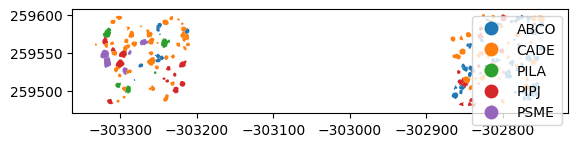

In [11]:
# Load the data
gdf = gpd.read_file(LABELS_FILENAME)

gdf.query(f"fire=='{SHORT_MODEL_NAME}'").plot(
    LABELS_COLUMN, legend=True, vmin=0, vmax=9
)

# Load a set of cameras and downsample them to the region around annotations

In [12]:
IMAGE_FOLDER = get_image_folder(SHORT_MODEL_NAME)
IMAGE_FOLDER_OBLIQUE = get_oblique_images_folder(SHORT_MODEL_NAME)
CAMERAS_FILENAME = get_camera_filename(SHORT_MODEL_NAME)

# Create camera set
camera_set = MetashapeCameraSet(CAMERAS_FILENAME, IMAGE_FOLDER)
# Extract cameras near the training data
training_camera_set = camera_set.get_subset_ROI(
    ROI=LABELS_FILENAME, buffer_radius_meters=BUFFER_RADIUS_METERS
)
training_camera_set = training_camera_set.get_cameras_in_folder(IMAGE_FOLDER_OBLIQUE)
training_camera_set.vis(force_xvfb=True, frustum_scale=0.5)

KeyboardInterrupt: 

# Load the mesh and read texture from geopolygon

In [ ]:
MESH_FILENAME = get_mesh_filename(SHORT_MODEL_NAME)
LABELED_MESH_FILENAME = get_labeled_mesh_filename(SHORT_MODEL_NAME)
DTM_FILENAME = get_DTM_filename(SHORT_MODEL_NAME)


# Create a labeled version of the mesh from the field data
# if not present or requested
if not Path(LABELED_MESH_FILENAME).is_file() or RETEXTURE:
    # Load the downsampled mesh and apply the texture from the vector file
    mesh = TexturedPhotogrammetryMesh(
        MESH_FILENAME,
        downsample_target=DOWNSAMPLE_TARGET,
        ROI=LABELS_FILENAME,
        ROI_buffer_meters=BUFFER_RADIUS_METERS,
        texture=LABELS_FILENAME,
        texture_column_name=LABELS_COLUMN,
        transform_filename="/ofo-share/str-disp_drone-data-partial/imagery-processed/outputs/120m-01/Lassic-120m_20240213T0503_cameras.xml",
    )
    
    # Label the ground class
    mesh.label_ground_class(
        DTM_file=DTM_FILENAME,
        height_above_ground_threshold=HEIGHT_ABOVE_GROUND_THRESH,
        only_label_existing_labels=True,
        ground_class_name="ground",
        ground_ID=np.nan,
        set_mesh_texture=True,
    )

    mesh.save_mesh(LABELED_MESH_FILENAME, save_vert_texture=True)
else:
    mesh = TexturedPhotogrammetryMesh(
        LABELED_MESH_FILENAME, transform_filename=CAMERAS_FILENAME
    )
class_names = mesh.get_label_names()
print(f"IDs to labels: {mesh.IDs_to_labels}")

# Show the mesh

In [ ]:
# You can include the camera set, but it's cleaner without it
mesh.vis(camera_set=None, force_xvfb=True, interactive_jupyter=True)

# Render the labels onto the images

In [ ]:
RENDER_FOLDER_SCRATCH = get_render_scratch_folder(SHORT_MODEL_NAME)

mesh.save_renders_pytorch3d(
    camera_set=training_camera_set,
    render_image_scale=RENDER_IMAGE_SCALE,
    save_native_resolution=True,
    output_folder=RENDER_FOLDER_SCRATCH,
)

# Save out the subset of images near the labels

In [ ]:
IMAGES_NEAR_LABELS_FOLDER = get_images_near_labels_folder(SHORT_MODEL_NAME)

if not IMAGES_NEAR_LABELS_FOLDER.is_dir():
    print(f"Saving subset of images near labels to {IMAGES_NEAR_LABELS_FOLDER}")
    training_camera_set.save_images(IMAGES_NEAR_LABELS_FOLDER)

# Show some of the rendered labels

In [ ]:
show_segmentation_labels(label_folder=RENDER_FOLDER_SCRATCH, image_folder=IMAGE_FOLDER)

# Copy files from scratch

In [ ]:
RENDER_FOLDER = get_render_folder(SHORT_MODEL_NAME)
shutil.copytree(src=RENDER_FOLDER_SCRATCH, dst=RENDER_FOLDER, dirs_exist_ok=True)